In [2]:
# %% # Imports
# -*- coding: utf-8 -*-
"""
This script analyzes neural and behavioral data in a multi-area calcium imaging
dataset with labeled projection neurons. The visual stimuli are natural images.
Matthijs Oude Lohuis, 2023, Champalimaud Center
"""

# Import general libs
from sklearn.preprocessing import normalize
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn import preprocessing

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'molanalysis' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('molanalysis')[0] + 'molanalysis'
else:
    raise FileNotFoundError(
        'This needs to be run from within the molanalysis folder')
os.chdir(current_path)

In [3]:
# %% # Import personal lib funcs
from loaddata.session_info import filter_sessions, load_sessions
from utils.plotting_style import *  # get all the fixed color schemes
from utils.imagelib import load_natural_images
from utils.explorefigs import *
from utils.psth import compute_tensor, compute_respmat, construct_behav_matrix_ts_F
from loaddata.get_data_folder import get_local_drive
from utils.corr_lib import mean_resp_image, compute_signal_correlation, compute_pairwise_metrics


# Updated by Anastasia Simonoff for her local computer, etc.

savedir = os.path.join(get_local_drive(
), 'Users\\asimo\\Documents\\BCCN\\Lab Rotations\\Petreanu Lab\\Figures\\Images' if os.environ['USERDOMAIN'] == 'ULTINTELLIGENCE' else 'OneDrive\\PostDoc\\Figures\\Images\\')

In [4]:
# %% Load one session including raw data: ################################################
# example session with good responses
session_list = np.array([['LPE11086', '2023_12_16']])

# Load sessions lazy: (no calciumdata, behaviordata etc.,)
sessions, nSessions = load_sessions(protocol='IM', session_list=session_list)

# Load proper data and compute average trial responses:
for ises in range(nSessions):    # iterate over sessions
    sessions[ises].load_respmat(calciumversion='deconv', keepraw=True)

['IM'] dataset: 1 mice, 1 sessions, 5600 trials
Neurons in area:
roi_name
PM     883
V1    1653
Name: roi_name, dtype: int64
Loading calcium data at C:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\molanalysis\data\IM\LPE11086\2023_12_16\deconvdata.csv
Computing average response for trial 5600 / 5600
pupil respmat here!!!!



In [5]:

# #%% Load all IM sessions including raw data: ################################################
# sessions,nSessions   = filter_sessions(protocols = ['IM'])
# for ises in range(nSessions):    # iterate over sessions
#     sessions[ises].load_respmat(calciumversion='deconv',keepraw=False)

In [6]:
# %% ### Load the natural images:
natimgdata = load_natural_images(onlyright=True)

[2747, 2827]


c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\molanalysis\utils\explorefigs.py:181: RuntimeWarning: invalid value encountered in cast
  example_cells   = np.empty((len(areas),len(labeled),nexcells)).astype('int64')


[3294, 3374]


C:\Users\asimo\AppData\Local\Temp\ipykernel_4888\2402861345.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[3704, 3784]
normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.01sec
sorting activity: 830 valid samples by 583 timepoints
n_PCs = 100 computed, 0.40sec
50 clusters computed, time 0.55sec
clusters sorted, time 1.10sec
clusters upsampled, time 1.30sec
rastermap complete, time 1.31sec
normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.00sec
sorting activity: 53 valid samples by 583 timepoints
n_PCs = 53 computed, 0.10sec
26 clusters computed, time 0.11sec
clusters sorted, time 0.14sec
clusters upsampled, time 0.23sec
rastermap complete, time 0.23sec
normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.02sec
sorting activity: 1561 valid samples by 583 timepoints
n_PCs = 100 computed, 0.47sec
50 clusters computed, time 0.72sec
clusters sorted, time 1.43sec
clusters upsampled, time 1.65sec
rastermap complete, time 1.65sec
normalizing data across axis=1
projecting out mean along axis=0
data normali

C:\Users\asimo\AppData\Local\Temp\ipykernel_4888\2402861345.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


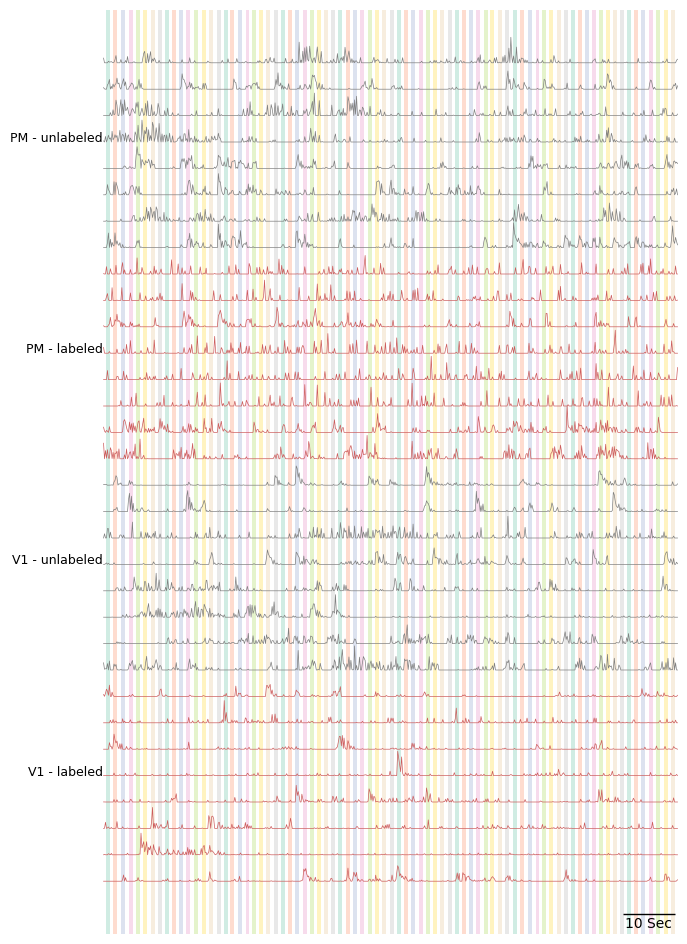

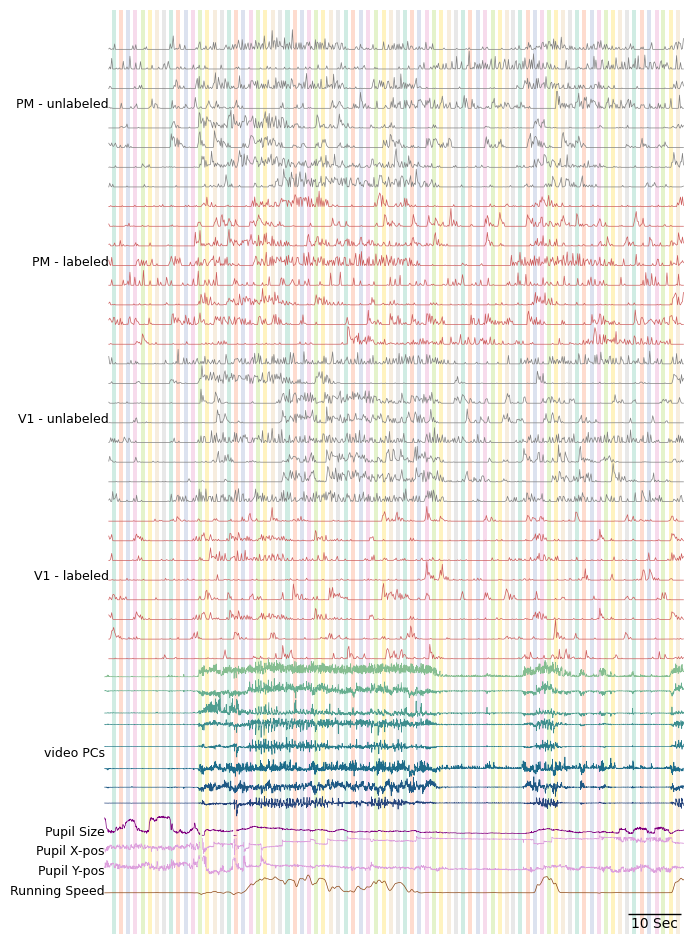

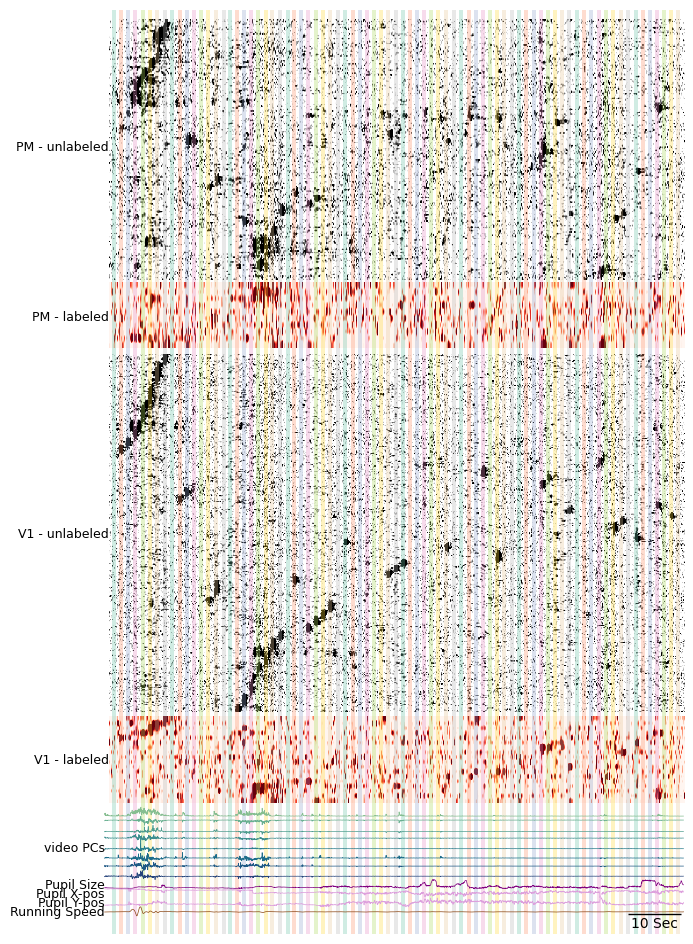

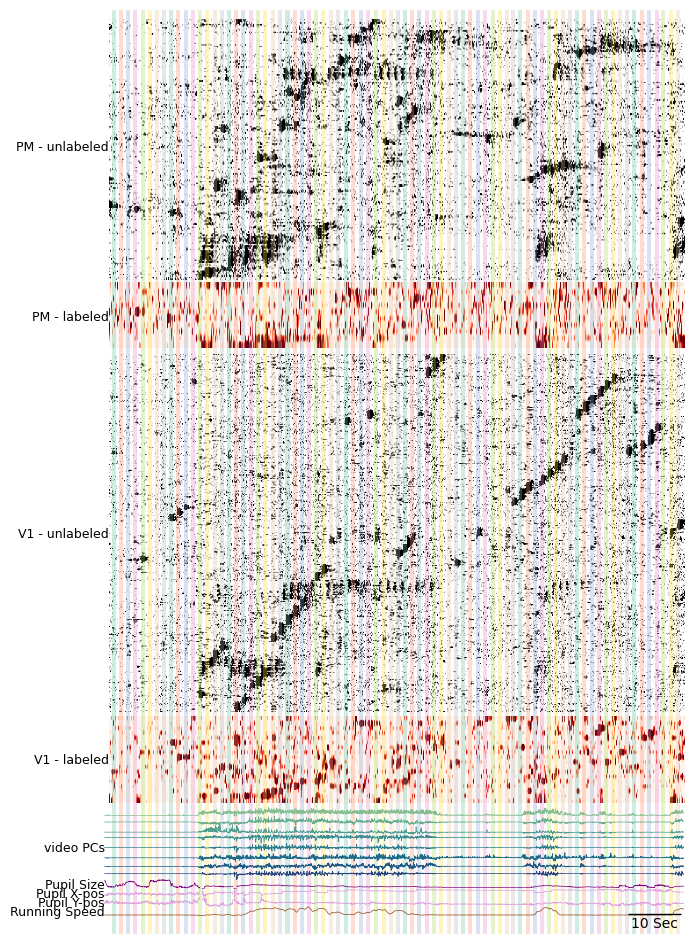

In [7]:
# %% ###############################################################
# Show some traces and some stimuli to see responses:

sesidx = 0

# Plot random excerpt with traces:
fig = plot_excerpt(sessions[sesidx], trialsel=None,
                   plot_neural=True, plot_behavioral=False)

# plot specific trials with a lot behavior related modulation:
trialsel = [3294, 3374]
fig = plot_excerpt(sessions[sesidx], trialsel=trialsel,
                   plot_neural=True, plot_behavioral=True, neural_version='traces')
# fig.savefig(os.path.join(savedir,'TraceExcerpt_dF_' + sessions[sesidx].sessiondata['session_id'][0] + '.png'), format = 'png')
# fig.savefig(os.path.join(savedir, 'Excerpt_Traces_deconv_' +
#             sessions[sesidx].sessiondata['session_id'][0] + '.png'), format='png')
fig.show()

# Plot random excerpt as a Rastermap (Stringer et al 2023 BioRxiv):

fig = plot_excerpt(sessions[sesidx], trialsel=None, plot_neural=True,
                   plot_behavioral=True, neural_version='raster')
fig = plot_excerpt(sessions[sesidx], trialsel=trialsel,
                   plot_neural=True, plot_behavioral=True, neural_version='raster')
# fig.savefig(os.path.join(savedir, 'Excerpt_Raster_dF_' +
#             sessions[sesidx].sessiondata['session_id'][0] + '.png'), format='png')
fig.show()

c:\Users\asimo\.conda\envs\molanalysis\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\asimo\AppData\Local\Temp\ipykernel_4888\1198828269.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


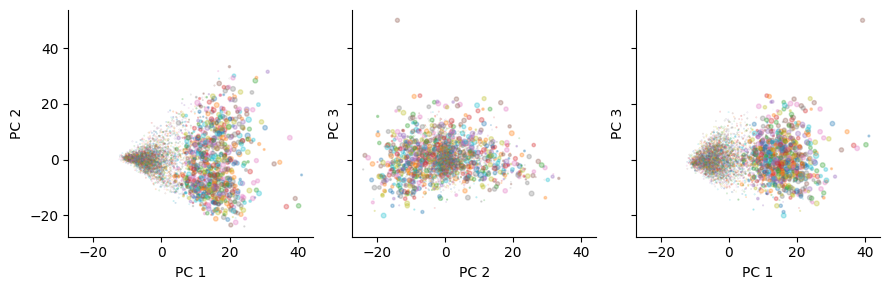

In [8]:
# %% ########################## Show PCA to get sense of dominant variability ##########################
sesidx = 0

fig = plot_PCA_images(sessions[sesidx])
# fig.savefig(os.path.join(savedir, 'PCA', 'PCA_Gratings_All_' +
#             sessions[sesidx].sessiondata['session_id'][0] + '.png'), format='png')
fig.show()

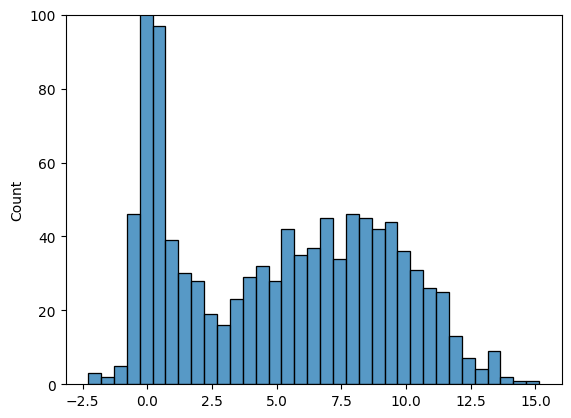

In [9]:
fig = plt.figure()
sns.histplot(sessions[sesidx].respmat_runspeed, binwidth=0.5)
plt.ylim([0, 100])
plt.show()

In [ ]:
# %%
sesidx = 0

sessions[sesidx].trialdata['repetition'] = np.r_[
    np.zeros([2800]), np.ones([2800])]

# Sort based on image number:
arr1inds = sessions[sesidx].trialdata['ImageNumber'][:2800].argsort()
arr2inds = sessions[sesidx].trialdata['ImageNumber'][2800:5600].argsort()

respmat = sessions[sesidx].respmat[:, np.r_[arr1inds, arr2inds+2800]]
# respmat_sort = sessions[sesidx].respmat_z[:,np.r_[arr1inds,arr2inds+2800]]


min_max_scaler = preprocessing.MinMaxScaler()
respmat_sort = preprocessing.minmax_scale(
    respmat, feature_range=(0, 1), axis=0, copy=True)

respmat_sort = normalize(respmat, 'l2', axis=1)

fig, axes = plt.subplots(1, 2, figsize=(17, 7))
# fig, axes = plt.subplots(2, 1, figsize=(7, 17))

# axes[0].imshow(respmat_sort[:,:2800], aspect='auto',vmin=-100,vmax=200)
axes[0].imshow(respmat_sort[:, :2800], aspect='auto', vmin=np.percentile(
    respmat_sort, 5), vmax=np.percentile(respmat_sort, 95))
axes[0].set_xlabel('Image #')
axes[0].set_ylabel('Neuron')
axes[0].set_title('Repetition 1')
# axes[1].imshow(respmat_sort[:,2800:], aspect='auto',vmin=-100,vmax=200)
axes[1].imshow(respmat_sort[:, 2800:], aspect='auto', vmin=np.percentile(
    respmat_sort, 5), vmax=np.percentile(respmat_sort, 95))
axes[1].set_xlabel('Image #')
axes[1].set_ylabel('Neuron')
plt.tight_layout(rect=[0, 0, 1, 1])
axes[1].set_title('Repetition 2')



In [ ]:
# %% ##### Show response-triggered frame for cells:
for ises in range(nSessions):
    nImages = len(np.unique(sessions[ises].trialdata['ImageNumber']))
    nNeurons = np.shape(sessions[ises].respmat)[0]
    sessions[ises].respmat_image = np.empty((nNeurons, nImages))
    for iIm in range(nImages):
        sessions[ises].respmat_image[:, iIm] = np.mean(
            sessions[sesidx].respmat[:, sessions[sesidx].trialdata['ImageNumber'] == iIm], axis=1)

    # Compute response triggered average image:
    sessions[ises].RTA = np.empty((*np.shape(natimgdata)[:2], nNeurons))

    for iN in range(nNeurons):
        print(
            f"\rComputing average response for neuron {iN+1} / {nNeurons}", end='\r')
        sessions[ises].RTA[:, :, iN] = np.average(
            natimgdata, axis=2, weights=sessions[ises].respmat_image[iN, :])


In [ ]:
# %% #### Plot X examples from V1 and PM with high variance in the average image (capturing some consistent preference): ####
RTA_var = np.var(sessions[ises].RTA, axis=(0, 1))

nExamples = 25
areas = ['V1', 'PM']

for area in areas:
    temp = RTA_var
    temp[sessions[ises].celldata['roi_name'] != area] = 0

    example_cells = np.argsort(temp)[-nExamples:]

    Rows = int(np.floor(np.sqrt(nExamples)))
    Cols = nExamples // Rows  # Compute Rows required
    if nExamples % Rows != 0:  # If one additional row is necessary -> add one:
        Cols += 1
    Position = range(1, nExamples + 1)  # Create a Position index

    fig = plt.figure(figsize=[18, 9])
    for i, n in enumerate(example_cells):
        # add every single subplot to the figure with a for loop
        ax = fig.add_subplot(Rows, Cols, Position[i])
        # ,vmin=100,vmax=150)
        plt.imshow(sessions[ises].RTA[:, :, n], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
        ax.set_title("%d" % n)
    plt.suptitle(area, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 1])
    # fig.savefig(os.path.join(savedir,'ResponseTriggeredAverageImage_%s' % area + sessions[sesidx].sessiondata['session_id'][0] + '.png'), format = 'png')


####

respmean = mean_resp_image(sessions[sesidx])


# We start working from here with convolutional feature maps / deep generative models:

# https://github.com/cajal/inception_loop2019

# https://github.com/sacadena/Cadena2019PlosCB

# https://github.com/dicarlolab/convmap
